In [17]:
!pip install --upgrade "numpy<2"


In [18]:
!pwd

/content/drive/My Drive/Projects/rl/DDPG-Pytorch


In [19]:
ls

configs/  LICENSE  main.py  pretrained_models/  src/  test.py  train.py  wandb/


In [3]:
cd drive/MyDrive/Projects/rl

/content/drive/MyDrive/Projects/rl


In [4]:
# !git clone https://github.com/sainijagjit/DDPG-Pytorch.git

In [5]:
cd DDPG-Pytorch/

/content/drive/MyDrive/Projects/rl/DDPG-Pytorch


In [20]:
# !apt-get install -y swig
!pip install gym==0.26.2

In [26]:
# point_particle_env.py
import  gym
from typing import Optional
import numpy as np
# import gym
from gym import spaces
from gym.utils import seeding
import pygame
from pygame import gfxdraw

class PointParticleEnv(gym.Env):
    """
    Continuous 2D navigation with interior obstacles and boundary walls.
    - State: [x, y, heading] (plus flattened obstacles if obs=True)
    - Action: heading angle in degrees [action_min, action_max]
    - Reward:
        * +goal_reward on reaching the goal
        * -obstacle_penalty if bumping an obstacle
        * -wall_penalty     if pushing against a boundary
        * otherwise = -distance_to_goal
    - Episode ends (terminated) on goal; truncated on time-limit.
    """
    metadata = {'render.modes': ['human', 'rgb_array']}

    def __init__(self,
                 size=(50, 50),
                 goal=None,
                 exploring_starts: bool=False,
                 obs: bool=False,
                 action_range=(0, 180),
                 max_episode_steps: int = 500,
                 obstacle_penalty: float = 50.0,
                 wall_penalty: float = 100.0,
                 goal_reward: float = 500.0,
                 render_mode=False):
        super().__init__()
        # —— seeding for reproducibility
        self.seed()

        # —— env parameters
        self.size = np.array(size, dtype=np.float32)
        self.speed = 5.0
        self.goal = np.array([45.0, 45.0], dtype=np.float32) \
                    if goal is None else np.array(goal, dtype=np.float32)
        self.exploring_starts = exploring_starts
        self.obs = obs
        self.action_min, self.action_max = action_range

        # —— penalties & rewards
        self.obstacle_penalty = obstacle_penalty
        self.wall_penalty     = wall_penalty
        self.goal_reward      = goal_reward

        # —— time‐limit bookkeeping
        self.max_episode_steps = max_episode_steps
        self.current_step      = 0

        # —— action & observation spaces
        self.action_space = spaces.Box(
            low  = np.array([self.action_min], dtype=np.float32),
            high = np.array([self.action_max], dtype=np.float32),
            dtype=np.float32
        )

        # define some interior rectangular obstacles (x1,y1,x2,y2)
        self.obstacles = [
            (12, 12, 25, 15),
            (25, 25, 27, 37)
        ]

        # observation space: [x, y, heading] + obstacles if obs=True
        if self.obs:
            obs_low  = np.zeros(4 * len(self.obstacles), dtype=np.float32)
            obs_high = np.concatenate((self.size, [360])).astype(np.float32)
            self.observation_space = spaces.Box(
                low  = np.concatenate(([0, 0, 0], obs_low)),
                high = np.concatenate((obs_high, obs_low + self.size[0])),
                dtype=np.float32
            )
        else:
            self.observation_space = spaces.Box(
                low  = np.array([0, 0, 0], dtype=np.float32),
                high = np.array([*self.size, 360], dtype=np.float32),
                dtype=np.float32
            )

        # internal
        self.state  = None
        self.screen = None

    def seed(self, seed: Optional[int]=None):
        """Gym-style seeding."""
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def reset(self, *, seed: Optional[int]=None, options=None):
        """Reset environment; return (obs, info)."""
        if seed is not None:
            self.seed(seed)
        self.current_step = 0

        if self.exploring_starts:
            x       = self.np_random.uniform(0, self.size[0])
            y       = self.np_random.uniform(0, self.size[1])
            heading = self.np_random.uniform(self.action_min, self.action_max)
        else:
            x, y, heading = 10.0, 10.0, 0.0

        if self.obs:
            flat_obs   = np.array(self.obstacles).flatten().astype(np.float32)
            self.state  = np.concatenate(([x, y, heading], flat_obs))
        else:
            self.state  = np.array([x, y, heading], dtype=np.float32)

        return self.state, {}

    def is_collision(self, x: float, y: float) -> bool:
        """Check interior obstacles only."""
        for x1, y1, x2, y2 in self.obstacles:
            if x1 <= x <= x2 and y1 <= y <= y2:
                return True
        return False


    def _line_intersects_rectangle(self, x0, y0, x1, y1, rect):
            xmin, ymin, xmax, ymax = rect
            # Handle zero-movement case
            if x0 == x1 and y0 == y1:
                return (xmin <= x0 <= xmax) and (ymin <= y0 <= ymax)

            dx, dy = x1 - x0, y1 - y0
            p = [-dx, dx, -dy, dy]
            q = [x0 - xmin, xmax - x0, y0 - ymin, ymax - y0]
            t0, t1 = 0.0, 1.0

            for i in range(4):
                if abs(p[i]) < 1e-10:  # Parallel to edge
                    if q[i] < 0: return False
                else:
                    t = q[i] / p[i]
                    if p[i] < 0:
                        if t > t1: return False
                        if t > t0: t0 = t
                    else:
                        if t < t0: return False
                        if t < t1: t1 = t

            return t0 <= t1 and t0 <= 1 and t1 >= 0

    def step(self, action):
        """Apply action, return (next_state, reward, terminated, truncated, info)."""
        self.current_step += 1
        result = self._simulate_step(self.state, action)
        new_state, base_reward, terminated, hit_obstacle, hit_wall, info = result

        reward = base_reward
        if hit_obstacle:
            reward -= self.obstacle_penalty
        if hit_wall:
            reward -= self.wall_penalty
        if terminated:
            reward += self.goal_reward

        # truncation on time-limit
        truncated = (self.current_step >= self.max_episode_steps)
        # update state
        self.state = new_state

        return new_state, reward, terminated, truncated,info

    def _simulate_step(self, state, action):
        """Compute next_state, base_reward, terminated (no penalties here)."""
        pos = state[:2]
        current_heading = state[2]
        alpha = 0.3
        # Convert action to relative heading change
        delta_heading = float(action[0])
        new_heading = ((1-alpha)*current_heading + alpha*delta_heading) % 360  # Keep in [0,360)
        dx = self.speed * np.cos(np.radians(new_heading))
        dy = self.speed * np.sin(np.radians(new_heading))
        new_x, new_y = pos[0] + dx, pos[1] + dy

        # Continuous obstacle collision check
        hit_obstacle = any(
            self._line_intersects_rectangle(pos[0], pos[1], new_x, new_y, obs)
            for obs in self.obstacles
        )

        # Wall collision (endpoint only - walls are convex)
        hit_wall = not (0 <= new_x <= self.size[0] and 0 <= new_y <= self.size[1])

        # Roll back position on collision
        if hit_obstacle or hit_wall:

            new_x, new_y = pos[0], pos[1]

        # clip to exact bounds
        new_x = np.clip(new_x, 0, self.size[0])
        new_y = np.clip(new_y, 0, self.size[1])

        if self.obs:
            obs_data  = state[3:]
            new_state = np.concatenate(([new_x, new_y, new_heading], obs_data))
        else:
            new_state = np.array([new_x, new_y, new_heading], dtype=np.float32)

        # base reward = negative distance to goal
        distance   = np.linalg.norm(new_state[:2] - self.goal)
        base_reward = -distance

        # termination when close to goal
        terminated = (distance < 5.0)

        return new_state, base_reward, terminated, hit_obstacle, hit_wall, {}

    def render(self, mode='human'):
        """Draw agent, goal, obstacles, and walls."""
        screen_size = 600
        scale = screen_size / max(self.size)

        if self.screen is None:
            pygame.init()
            self.screen = pygame.Surface((screen_size, screen_size))

        surf = pygame.Surface((screen_size, screen_size))
        surf.fill((22, 36, 71))  # background

        # draw boundary walls (as gray frame)
        wall_thick = 5
        pygame.draw.rect(surf, (100,100,100), (0, 0, screen_size, wall_thick))  # top
        pygame.draw.rect(surf, (100,100,100), (0, 0, wall_thick, screen_size))  # left
        pygame.draw.rect(surf, (100,100,100), (0, screen_size-wall_thick, screen_size, wall_thick))  # bottom
        pygame.draw.rect(surf, (100,100,100), (screen_size-wall_thick, 0, wall_thick, screen_size))  # right

        # draw goal
        gx = int(self.goal[0] * scale)
        gy = screen_size - int(self.goal[1] * scale)
        gfxdraw.filled_circle(surf, gx, gy, int(scale*2), (40,199,172))

        # draw obstacles
        for x1, y1, x2, y2 in self.obstacles:
            rx = int(x1*scale)
            ry = screen_size - int(y2*scale)
            w  = int((x2-x1)*scale)
            h  = int((y2-y1)*scale)
            pygame.draw.rect(surf, (128,128,128), (rx, ry, w, h))

        # draw agent
        ax = int(self.state[0]*scale)
        ay = screen_size - int(self.state[1]*scale)
        gfxdraw.filled_circle(surf, ax, ay, int(scale*1), (228,63,90))
        # heading line
        end_x = ax + int(10*np.cos(np.radians(self.state[2])))
        end_y = ay - int(10*np.sin(np.radians(self.state[2])))
        pygame.draw.line(surf, (255,255,255), (ax,ay), (end_x,end_y), 2)

        canvas = pygame.transform.flip(surf, False, True)
        self.screen.blit(canvas, (0,0))

        if mode=='human':
            pygame.display.flip()
            return None
        elif mode=='rgb_array':
            arr = pygame.surfarray.pixels3d(self.screen)
            return np.transpose(arr, (1,0,2)).astype(np.uint8)
        else:
            raise ValueError(f"Render mode {mode} not supported")

    def close(self):
        """Shutdown pygame."""
        if self.screen is not None:
            pygame.display.quit()
            pygame.quit()
            self.screen = None


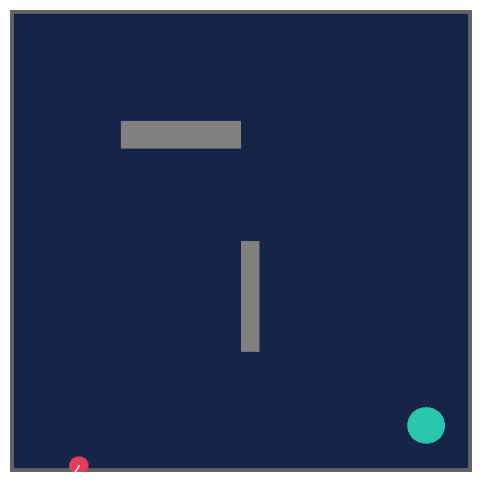

In [23]:
# Create environment with obstacles in state
env = PointParticleEnv()
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

def run_random_agent_animation(env, steps=500):
    frames = []
    state = env.reset()
    for _ in range(steps):
        # Sample a random action from the continuous action space
        action = env.action_space.sample()
        state, reward, done,_,info = env.step(action)
        frame = env.render(mode='rgb_array')
        frames.append(frame)
        if done:
            break
    return frames

# Create environment instance (with obstacles and continuous actions)
env = PointParticleEnv(obs=True)

# Run the agent for 50 random steps and collect frames
frames = run_random_agent_animation(env, steps=150)

# Create animation using matplotlib
fig, ax = plt.subplots(figsize=(6, 6))
ax.axis('off')
im = ax.imshow(frames[0])

def update(frame):
    im.set_data(frame)
    return [im]

anim = animation.FuncAnimation(fig, update, frames=frames, interval=100, blit=True)

# Display animation as HTML video (for Jupyter notebooks)
HTML(anim.to_html5_video())



In [27]:
import os
import wandb
# import gym
import json
import torch
import numpy as np
from tqdm import tqdm
from src.utils import *
from src.memory import *
from src.agents import *

os.environ['WANDB_API_KEY'] = ''
class Trainer:

    def __init__(self, config_file, enable_logging=True):
        self.enable_logging = enable_logging
        self.config = Trainer.parse_config(config_file)
        self.env =  gym.make(self.config['env_name'])
        self.env = apply_seed(self.env,self.config['seed'])
        self.state_dimension = self.env.observation_space.shape[0]
        print("state",self.state_dimension)
        self.action_dimension = self.env.action_space.shape[0]
        print("action",self.action_dimension)
        self.max_action = float(self.env.action_space.high[0])
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.agent = DDPGAgent(
            state_dim=self.state_dimension, action_dim=self.action_dimension,
            max_action=self.max_action, device=self.device,
            discount=self.config['discount'], tau=self.config['tau']
        )
        self.save_file_name = f"DDPG_{self.config['env_name']}_{self.config['seed']}"
        self.memory = ReplayBuffer()
        if self.enable_logging:
            wandb.init(project="ddpg", config=self.config)
        try:
            os.mkdir('./pretrained_models')
        except Exception as e:
            pass

    @staticmethod
    def parse_config(json_file):
        with open(json_file, 'r') as f:
            configs = json.load(f)
        return configs

    def train(self):
        # pull out your new config entries:
        num_episodes     = 500
        max_episode_steps = int(self.config.get('max_episode_steps', self.env._max_episode_steps))

        ts = 0                                 # global time-step counter
        episode_rewards = []
        evaluations     = []

        for ep in tqdm(range(1, num_episodes + 1)):
            print("episode number is: ",ep)
            state, info = self.env.reset()
            episode_reward, episode_timesteps = 0, 0
            done = False

            # run one episode (stop if env says done OR if we hit max_episode_steps)
            while not done and episode_timesteps < max_episode_steps:
                # print("episode_timesteps: ",episode_timesteps)
                episode_timesteps += 1
                ts += 1

                # select action
                if ts < self.config['start_time_step']:
                    action = self.env.action_space.sample()
                else:
                    action = (
                        self.agent.select_action(np.array(state))
                        + np.random.normal(0, self.max_action * self.config['expl_noise'], size=self.action_dimension)
                    ).clip(-self.max_action, self.max_action)

                # step the env
                next_state, reward, done, trunc ,info = self.env.step(action)

                # push into replay, using 0‐mask if we ended because of time-limit
                time_limit_reached = (episode_timesteps >= max_episode_steps)
                mask = float(done) if not time_limit_reached else 0.0
                self.memory.push(state, action, reward, next_state, mask)

                state = next_state
                episode_reward += reward

                # train after warm-up
                if ts >= self.config['start_time_step']:
                    self.agent.train(self.memory, self.config['batch_size'])

            # end of this episode: logging + reset counters
            if self.enable_logging:
                wandb.log({'Episode': ep,
                          'Episode Reward': episode_reward,
                          'Episode Length': episode_timesteps,
                          'Global Step': ts})

            episode_rewards.append(episode_reward)

            # every 100 episodes, evaluate+checkpoint
            if ep % 10 == 0:
                eval_score = evaluate_policy(
                    self.agent,
                    self.config['env_name'],
                    self.config['seed'],
                    enable_logging=self.enable_logging,
                    wandb=wandb
                )
                evaluations.append(eval_score)
                self.agent.save_checkpoint(f"./pretrained_models/{self.save_file_name}")

        wandb.finish()
        return episode_rewards, evaluations


    def evaluate(self):
        self.agent.load_checkpoint(f"./pretrained_models/DDPG_{self.config['env_name']}_{self.config['seed']}")
        evaluate_policy(self.agent, self.config['env_name'], self.config['seed'],render=True)

state 3
action 1


/usr/local/lib/python3.11/dist-packages/gym/envs/registration.py:498: UserWarning: WARN: Overriding environment PointParticle-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


Episode,▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
Episode Length,████████████████████████████████████▃▁▁▁
Episode Reward,▁▂▂▂▁▃▁▃▂▂▂▂▁▁▁▂▂▃▁▁▁▁▃▂▁▁▁▃▃▁▂▁▁▁▁█████
Global Step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████████
Test Episode Reward,▁▁▁▁▁▁▁▁█
Episode,92
Episode Length,50
Episode Reward,-1167.70689
Global Step,25450
Test Episode Reward,-1135.98792


  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
  1%|          | 3/500 [00:00<00:24, 20.60it/s]

episode number is:  1
episode number is:  2
episode number is:  3
episode number is:  4
episode number is:  5


  2%|▏         | 8/500 [00:00<00:24, 19.74it/s]

episode number is:  6
episode number is:  7
episode number is:  8
episode number is:  9
episode number is:  10
Episode reward 1 ==> -27460.587657928467
Episode reward 2 ==> -27460.587657928467
Episode reward 3 ==> -27460.587657928467
Episode reward 4 ==> -27460.587657928467
Episode reward 5 ==> -27460.587657928467
Episode reward 6 ==> -27460.587657928467
Episode reward 7 ==> -27460.587657928467
Episode reward 8 ==> -27460.587657928467
Episode reward 9 ==> -27460.587657928467


  2%|▏         | 12/500 [00:02<01:57,  4.15it/s]

Episode reward 10 ==> -27460.587657928467
episode number is:  11
episode number is:  12
episode number is:  13


  3%|▎         | 17/500 [00:02<01:01,  7.88it/s]

episode number is:  14
episode number is:  15
episode number is:  16
episode number is:  17
episode number is:  18
episode number is:  19
episode number is:  20
Episode reward 1 ==> -27460.587657928467
Episode reward 2 ==> -27460.587657928467
Episode reward 3 ==> -27460.587657928467
Episode reward 4 ==> -27460.587657928467
Episode reward 5 ==> -27460.587657928467
Episode reward 6 ==> -27460.587657928467
Episode reward 7 ==> -27460.587657928467
Episode reward 8 ==> -27460.587657928467
Episode reward 9 ==> -27460.587657928467
Episode reward 10 ==> -27460.587657928467


  5%|▍         | 23/500 [00:04<01:43,  4.61it/s]

episode number is:  21
episode number is:  22
episode number is:  23
episode number is:  24
episode number is:  25


  6%|▌         | 28/500 [00:04<01:03,  7.43it/s]

episode number is:  26
episode number is:  27
episode number is:  28
episode number is:  29
episode number is:  30
Episode reward 1 ==> -27460.587657928467
Episode reward 2 ==> -27460.587657928467
Episode reward 3 ==> -27460.587657928467
Episode reward 4 ==> -27460.587657928467
Episode reward 5 ==> -27460.587657928467
Episode reward 6 ==> -27460.587657928467
Episode reward 7 ==> -27460.587657928467
Episode reward 8 ==> -27460.587657928467
Episode reward 9 ==> -27460.587657928467
Episode reward 10 ==> -27460.587657928467


  7%|▋         | 33/500 [00:06<01:45,  4.41it/s]

episode number is:  31
episode number is:  32
episode number is:  33
episode number is:  34
episode number is:  35


  8%|▊         | 38/500 [00:06<01:02,  7.40it/s]

episode number is:  36
episode number is:  37
episode number is:  38
episode number is:  39
episode number is:  40
Episode reward 1 ==> -27460.587657928467
Episode reward 2 ==> -27460.587657928467
Episode reward 3 ==> -27460.587657928467
Episode reward 4 ==> -27460.587657928467
Episode reward 5 ==> -27460.587657928467
Episode reward 6 ==> -27460.587657928467
Episode reward 7 ==> -27460.587657928467
Episode reward 8 ==> -27460.587657928467


  8%|▊         | 40/500 [00:08<02:27,  3.12it/s]

Episode reward 9 ==> -27460.587657928467
Episode reward 10 ==> -27460.587657928467
episode number is:  41


  8%|▊         | 42/500 [00:08<01:55,  3.96it/s]

episode number is:  42
episode number is:  43
episode number is:  44


  9%|▉         | 46/500 [00:09<01:18,  5.82it/s]

episode number is:  45
episode number is:  46
episode number is:  47


 10%|▉         | 48/500 [00:09<01:06,  6.84it/s]

episode number is:  48
episode number is:  49
episode number is:  50
Episode reward 1 ==> -27460.587657928467
Episode reward 2 ==> -27460.587657928467
Episode reward 3 ==> -27460.587657928467
Episode reward 4 ==> -27460.587657928467
Episode reward 5 ==> -27460.587657928467
Episode reward 6 ==> -27460.587657928467
Episode reward 7 ==> -27460.587657928467
Episode reward 8 ==> -27460.587657928467
Episode reward 9 ==> -27460.587657928467


 10%|█         | 50/500 [00:11<03:28,  2.16it/s]

Episode reward 10 ==> -27460.587657928467
episode number is:  51
episode number is:  52


 11%|█         | 54/500 [00:12<01:58,  3.76it/s]

episode number is:  53
episode number is:  54
episode number is:  55


 11%|█         | 56/500 [00:12<01:32,  4.81it/s]

episode number is:  56
episode number is:  57
episode number is:  58


 12%|█▏        | 58/500 [00:12<01:16,  5.78it/s]

episode number is:  59
episode number is:  60
Episode reward 1 ==> -27460.587657928467
Episode reward 2 ==> -27460.587657928467
Episode reward 3 ==> -27460.587657928467
Episode reward 4 ==> -27460.587657928467
Episode reward 5 ==> -27460.587657928467
Episode reward 6 ==> -27460.587657928467
Episode reward 7 ==> -27460.587657928467
Episode reward 8 ==> -27460.587657928467
Episode reward 9 ==> -27460.587657928467


 13%|█▎        | 63/500 [00:14<02:08,  3.41it/s]

Episode reward 10 ==> -27460.587657928467
episode number is:  61
episode number is:  62
episode number is:  63
episode number is:  64


 14%|█▎        | 68/500 [00:14<01:11,  6.01it/s]

episode number is:  65
episode number is:  66
episode number is:  67
episode number is:  68
episode number is:  69
episode number is:  70
Episode reward 1 ==> -27460.587657928467
Episode reward 2 ==> -27460.587657928467
Episode reward 3 ==> -27460.587657928467
Episode reward 4 ==> -27460.587657928467
Episode reward 5 ==> -27460.587657928467
Episode reward 6 ==> -27460.587657928467
Episode reward 7 ==> -27460.587657928467
Episode reward 8 ==> -27460.587657928467
Episode reward 9 ==> -27460.587657928467


 15%|█▍        | 73/500 [00:16<01:44,  4.08it/s]

Episode reward 10 ==> -27460.587657928467
episode number is:  71
episode number is:  72
episode number is:  73
episode number is:  74


 16%|█▌        | 78/500 [00:17<01:00,  7.02it/s]

episode number is:  75
episode number is:  76
episode number is:  77
episode number is:  78
episode number is:  79
episode number is:  80
Episode reward 1 ==> -27460.587657928467
Episode reward 2 ==> -27460.587657928467
Episode reward 3 ==> -27460.587657928467
Episode reward 4 ==> -27460.587657928467
Episode reward 5 ==> -27460.587657928467
Episode reward 6 ==> -27460.587657928467
Episode reward 7 ==> -27460.587657928467
Episode reward 8 ==> -27460.587657928467
Episode reward 9 ==> -27460.587657928467


 17%|█▋        | 83/500 [00:19<01:37,  4.28it/s]

Episode reward 10 ==> -27460.587657928467
episode number is:  81
episode number is:  82
episode number is:  83
episode number is:  84
episode number is:  85


 17%|█▋        | 85/500 [00:21<03:26,  2.01it/s]

episode number is:  86
episode number is:  87


 17%|█▋        | 87/500 [00:25<05:54,  1.16it/s]

episode number is:  88


 18%|█▊        | 88/500 [00:27<07:03,  1.03s/it]

episode number is:  89


 18%|█▊        | 89/500 [00:28<07:47,  1.14s/it]

episode number is:  90
Episode reward 1 ==> -1185.987919807434
Episode reward 2 ==> -1185.987919807434
Episode reward 3 ==> -1185.987919807434
Episode reward 4 ==> -1185.987919807434
Episode reward 5 ==> -1185.987919807434
Episode reward 6 ==> -1185.987919807434


 18%|█▊        | 90/500 [00:30<08:25,  1.23s/it]

Episode reward 7 ==> -1185.987919807434
Episode reward 8 ==> -1185.987919807434
Episode reward 9 ==> -1185.987919807434
Episode reward 10 ==> -1185.987919807434
episode number is:  91


 18%|█▊        | 91/500 [00:31<08:28,  1.24s/it]

episode number is:  92


 18%|█▊        | 92/500 [00:32<08:21,  1.23s/it]

episode number is:  93


 19%|█▊        | 93/500 [00:34<08:14,  1.22s/it]

episode number is:  94


 19%|█▉        | 94/500 [00:35<08:13,  1.22s/it]

episode number is:  95


 19%|█▉        | 95/500 [00:36<08:17,  1.23s/it]

episode number is:  96


 19%|█▉        | 96/500 [00:37<07:46,  1.16s/it]

episode number is:  97


 19%|█▉        | 97/500 [00:39<08:50,  1.32s/it]

episode number is:  98


 20%|█▉        | 98/500 [00:41<10:53,  1.63s/it]

episode number is:  99


 20%|█▉        | 99/500 [00:43<11:14,  1.68s/it]

episode number is:  100
Episode reward 1 ==> -1185.987919807434
Episode reward 2 ==> -1185.987919807434
Episode reward 3 ==> -1185.987919807434
Episode reward 4 ==> -1185.987919807434
Episode reward 5 ==> -1185.987919807434
Episode reward 6 ==> -1185.987919807434
Episode reward 7 ==> -1185.987919807434


 20%|██        | 100/500 [00:45<11:27,  1.72s/it]

Episode reward 8 ==> -1185.987919807434
Episode reward 9 ==> -1185.987919807434
Episode reward 10 ==> -1185.987919807434
episode number is:  101


 20%|██        | 101/500 [00:46<10:57,  1.65s/it]

episode number is:  102


 20%|██        | 102/500 [00:48<10:21,  1.56s/it]

episode number is:  103


 21%|██        | 103/500 [00:49<09:56,  1.50s/it]

episode number is:  104


 21%|██        | 104/500 [00:50<09:37,  1.46s/it]

episode number is:  105


 21%|██        | 105/500 [00:52<09:16,  1.41s/it]

episode number is:  106


 21%|██        | 106/500 [00:53<08:48,  1.34s/it]

episode number is:  107


 21%|██▏       | 107/500 [00:55<10:11,  1.56s/it]

episode number is:  108


 22%|██▏       | 108/500 [00:57<11:36,  1.78s/it]

episode number is:  109


 22%|██▏       | 109/500 [00:59<10:40,  1.64s/it]

episode number is:  110
Episode reward 1 ==> -1185.987919807434
Episode reward 2 ==> -1185.987919807434
Episode reward 3 ==> -1185.987919807434
Episode reward 4 ==> -1185.987919807434
Episode reward 5 ==> -1185.987919807434
Episode reward 6 ==> -1185.987919807434
Episode reward 7 ==> -1185.987919807434


 22%|██▏       | 110/500 [01:00<10:45,  1.65s/it]

Episode reward 8 ==> -1185.987919807434
Episode reward 9 ==> -1185.987919807434
Episode reward 10 ==> -1185.987919807434
episode number is:  111


 22%|██▏       | 111/500 [01:02<10:18,  1.59s/it]

episode number is:  112


 22%|██▏       | 112/500 [01:03<09:45,  1.51s/it]

episode number is:  113


 23%|██▎       | 113/500 [01:04<09:19,  1.45s/it]

episode number is:  114


 23%|██▎       | 114/500 [01:06<09:06,  1.42s/it]

episode number is:  115


 23%|██▎       | 115/500 [01:07<08:54,  1.39s/it]

episode number is:  116


 23%|██▎       | 116/500 [01:08<08:59,  1.40s/it]

episode number is:  117


 23%|██▎       | 117/500 [01:10<10:13,  1.60s/it]

episode number is:  118


 24%|██▎       | 118/500 [01:12<10:59,  1.73s/it]

episode number is:  119


 24%|██▍       | 119/500 [01:14<10:10,  1.60s/it]

episode number is:  120
Episode reward 1 ==> -1185.987919807434
Episode reward 2 ==> -1185.987919807434
Episode reward 3 ==> -1185.987919807434
Episode reward 4 ==> -1185.987919807434
Episode reward 5 ==> -1185.987919807434
Episode reward 6 ==> -1185.987919807434
Episode reward 7 ==> -1185.987919807434


 24%|██▍       | 120/500 [01:15<10:18,  1.63s/it]

Episode reward 8 ==> -1185.987919807434
Episode reward 9 ==> -1185.987919807434
Episode reward 10 ==> -1185.987919807434
episode number is:  121


 24%|██▍       | 121/500 [01:17<09:49,  1.56s/it]

episode number is:  122


 24%|██▍       | 122/500 [01:18<09:24,  1.49s/it]

episode number is:  123


 25%|██▍       | 123/500 [01:19<09:01,  1.44s/it]

episode number is:  124


 25%|██▍       | 124/500 [01:21<08:45,  1.40s/it]

episode number is:  125


 25%|██▌       | 125/500 [01:22<08:53,  1.42s/it]

episode number is:  126


 25%|██▌       | 126/500 [01:24<09:02,  1.45s/it]

episode number is:  127


 25%|██▌       | 127/500 [01:26<10:08,  1.63s/it]

episode number is:  128


 26%|██▌       | 128/500 [01:28<10:17,  1.66s/it]

episode number is:  129


 26%|██▌       | 129/500 [01:29<09:37,  1.56s/it]

episode number is:  130
Episode reward 1 ==> -1185.987919807434
Episode reward 2 ==> -1185.987919807434
Episode reward 3 ==> -1185.987919807434
Episode reward 4 ==> -1185.987919807434
Episode reward 5 ==> -1185.987919807434
Episode reward 6 ==> -1185.987919807434
Episode reward 7 ==> -1185.987919807434


 26%|██▌       | 130/500 [01:31<09:50,  1.60s/it]

Episode reward 8 ==> -1185.987919807434
Episode reward 9 ==> -1185.987919807434
Episode reward 10 ==> -1185.987919807434
episode number is:  131


 26%|██▌       | 131/500 [01:32<09:27,  1.54s/it]

episode number is:  132


 26%|██▋       | 132/500 [01:33<09:03,  1.48s/it]

episode number is:  133


 27%|██▋       | 133/500 [01:35<08:42,  1.42s/it]

episode number is:  134


 27%|██▋       | 134/500 [01:36<08:29,  1.39s/it]

episode number is:  135


 27%|██▋       | 135/500 [01:38<09:10,  1.51s/it]

episode number is:  136


 27%|██▋       | 136/500 [01:39<09:07,  1.50s/it]

episode number is:  137


 27%|██▋       | 137/500 [01:41<09:56,  1.64s/it]

episode number is:  138


 28%|██▊       | 138/500 [01:43<09:51,  1.63s/it]

episode number is:  139


 28%|██▊       | 139/500 [01:44<09:17,  1.54s/it]

episode number is:  140
Episode reward 1 ==> -1185.987919807434
Episode reward 2 ==> -1185.987919807434
Episode reward 3 ==> -1185.987919807434
Episode reward 4 ==> -1185.987919807434
Episode reward 5 ==> -1185.987919807434
Episode reward 6 ==> -1185.987919807434
Episode reward 7 ==> -1185.987919807434


 28%|██▊       | 140/500 [01:46<09:38,  1.61s/it]

Episode reward 8 ==> -1185.987919807434
Episode reward 9 ==> -1185.987919807434
Episode reward 10 ==> -1185.987919807434
episode number is:  141


 28%|██▊       | 141/500 [01:47<09:14,  1.55s/it]

episode number is:  142


 28%|██▊       | 142/500 [01:49<08:57,  1.50s/it]

episode number is:  143


 29%|██▊       | 143/500 [01:50<08:34,  1.44s/it]

episode number is:  144


 29%|██▉       | 144/500 [01:51<08:37,  1.45s/it]

episode number is:  145


 29%|██▉       | 145/500 [01:53<09:30,  1.61s/it]

episode number is:  146


 29%|██▉       | 146/500 [01:55<09:20,  1.58s/it]

episode number is:  147


 29%|██▉       | 147/500 [01:57<09:21,  1.59s/it]

episode number is:  148


 30%|██▉       | 148/500 [01:58<09:20,  1.59s/it]

episode number is:  149


 30%|██▉       | 149/500 [01:59<08:53,  1.52s/it]

episode number is:  150
Episode reward 1 ==> -1185.987919807434
Episode reward 2 ==> -1185.987919807434
Episode reward 3 ==> -1185.987919807434
Episode reward 4 ==> -1185.987919807434
Episode reward 5 ==> -1185.987919807434
Episode reward 6 ==> -1185.987919807434
Episode reward 7 ==> -1185.987919807434


 30%|███       | 150/500 [02:01<09:13,  1.58s/it]

Episode reward 8 ==> -1185.987919807434
Episode reward 9 ==> -1185.987919807434
Episode reward 10 ==> -1185.987919807434
episode number is:  151


 30%|███       | 151/500 [02:03<08:53,  1.53s/it]

episode number is:  152


 30%|███       | 152/500 [02:04<08:33,  1.47s/it]

episode number is:  153


 31%|███       | 153/500 [02:05<08:12,  1.42s/it]

episode number is:  154


 31%|███       | 154/500 [02:07<08:49,  1.53s/it]

episode number is:  155


 31%|███       | 155/500 [02:09<09:30,  1.65s/it]

episode number is:  156


 31%|███       | 156/500 [02:10<09:06,  1.59s/it]

episode number is:  157


 31%|███▏      | 157/500 [02:12<08:42,  1.52s/it]

episode number is:  158


 32%|███▏      | 158/500 [02:13<08:43,  1.53s/it]

episode number is:  159


 32%|███▏      | 159/500 [02:15<08:17,  1.46s/it]

episode number is:  160
Episode reward 1 ==> -1185.987919807434
Episode reward 2 ==> -1185.987919807434
Episode reward 3 ==> -1185.987919807434
Episode reward 4 ==> -1185.987919807434
Episode reward 5 ==> -1185.987919807434
Episode reward 6 ==> -1185.987919807434
Episode reward 7 ==> -1185.987919807434


 32%|███▏      | 160/500 [02:16<08:37,  1.52s/it]

Episode reward 8 ==> -1185.987919807434
Episode reward 9 ==> -1185.987919807434
Episode reward 10 ==> -1185.987919807434
episode number is:  161


 32%|███▏      | 161/500 [02:18<08:20,  1.48s/it]

episode number is:  162


 32%|███▏      | 162/500 [02:19<08:04,  1.43s/it]

episode number is:  163


 33%|███▎      | 163/500 [02:20<07:53,  1.41s/it]

episode number is:  164


 33%|███▎      | 164/500 [02:22<08:42,  1.56s/it]

episode number is:  165


 33%|███▎      | 165/500 [02:24<09:20,  1.67s/it]

episode number is:  166


 33%|███▎      | 166/500 [02:25<08:35,  1.54s/it]

episode number is:  167


 33%|███▎      | 167/500 [02:27<08:18,  1.50s/it]

episode number is:  168


 34%|███▎      | 168/500 [02:28<08:24,  1.52s/it]

episode number is:  169


 34%|███▍      | 169/500 [02:30<08:04,  1.46s/it]

episode number is:  170
Episode reward 1 ==> -1185.987919807434
Episode reward 2 ==> -1185.987919807434
Episode reward 3 ==> -1185.987919807434
Episode reward 4 ==> -1185.987919807434
Episode reward 5 ==> -1185.987919807434
Episode reward 6 ==> -1185.987919807434
Episode reward 7 ==> -1185.987919807434


 34%|███▍      | 170/500 [02:31<08:25,  1.53s/it]

Episode reward 8 ==> -1185.987919807434
Episode reward 9 ==> -1185.987919807434
Episode reward 10 ==> -1185.987919807434
episode number is:  171


 34%|███▍      | 171/500 [02:33<08:10,  1.49s/it]

episode number is:  172


 34%|███▍      | 172/500 [02:34<07:53,  1.44s/it]

episode number is:  173


 35%|███▍      | 173/500 [02:36<08:04,  1.48s/it]

episode number is:  174


 35%|███▍      | 174/500 [02:38<08:45,  1.61s/it]

episode number is:  175


 35%|███▌      | 175/500 [02:40<09:13,  1.70s/it]

episode number is:  176


 35%|███▌      | 176/500 [02:41<08:04,  1.50s/it]

episode number is:  177


 35%|███▌      | 177/500 [02:42<07:51,  1.46s/it]

episode number is:  178


 36%|███▌      | 178/500 [02:44<08:01,  1.49s/it]

episode number is:  179


 36%|███▌      | 179/500 [02:45<07:41,  1.44s/it]

episode number is:  180
Episode reward 1 ==> -1185.987919807434
Episode reward 2 ==> -1185.987919807434
Episode reward 3 ==> -1185.987919807434
Episode reward 4 ==> -1185.987919807434
Episode reward 5 ==> -1185.987919807434
Episode reward 6 ==> -1185.987919807434
Episode reward 7 ==> -1185.987919807434


 36%|███▌      | 180/500 [02:47<08:05,  1.52s/it]

Episode reward 8 ==> -1185.987919807434
Episode reward 9 ==> -1185.987919807434
Episode reward 10 ==> -1185.987919807434
episode number is:  181


 36%|███▌      | 181/500 [02:48<07:50,  1.48s/it]

episode number is:  182


 36%|███▋      | 182/500 [02:49<07:34,  1.43s/it]

episode number is:  183


 37%|███▋      | 183/500 [02:51<08:04,  1.53s/it]

episode number is:  184


 37%|███▋      | 184/500 [02:53<08:41,  1.65s/it]

episode number is:  185


 37%|███▋      | 185/500 [02:55<08:40,  1.65s/it]

episode number is:  186


 37%|███▋      | 186/500 [02:56<07:40,  1.47s/it]

episode number is:  187


 37%|███▋      | 187/500 [02:57<07:29,  1.44s/it]

episode number is:  188


 38%|███▊      | 188/500 [02:59<07:40,  1.48s/it]

episode number is:  189


 38%|███▊      | 189/500 [03:00<07:23,  1.43s/it]

episode number is:  190
Episode reward 1 ==> -1185.987919807434
Episode reward 2 ==> -1185.987919807434
Episode reward 3 ==> -1185.987919807434
Episode reward 4 ==> -1185.987919807434
Episode reward 5 ==> -1185.987919807434
Episode reward 6 ==> -1185.987919807434


 38%|███▊      | 190/500 [03:02<07:48,  1.51s/it]

Episode reward 7 ==> -1185.987919807434
Episode reward 8 ==> -1185.987919807434
Episode reward 9 ==> -1185.987919807434
Episode reward 10 ==> -1185.987919807434
episode number is:  191


 38%|███▊      | 191/500 [03:03<07:35,  1.47s/it]

episode number is:  192


 38%|███▊      | 192/500 [03:04<07:35,  1.48s/it]

episode number is:  193


 39%|███▊      | 193/500 [03:06<08:14,  1.61s/it]

episode number is:  194


 39%|███▉      | 194/500 [03:08<08:47,  1.73s/it]

episode number is:  195


 39%|███▉      | 195/500 [03:10<08:16,  1.63s/it]

episode number is:  196


 39%|███▉      | 196/500 [03:11<07:19,  1.45s/it]

episode number is:  197


 39%|███▉      | 197/500 [03:12<07:11,  1.43s/it]

episode number is:  198


 40%|███▉      | 198/500 [03:14<07:23,  1.47s/it]

episode number is:  199


 40%|███▉      | 199/500 [03:15<07:07,  1.42s/it]

episode number is:  200
Episode reward 1 ==> -1185.987919807434
Episode reward 2 ==> -1185.987919807434
Episode reward 3 ==> -1185.987919807434
Episode reward 4 ==> -1185.987919807434
Episode reward 5 ==> -1185.987919807434
Episode reward 6 ==> -1185.987919807434
Episode reward 7 ==> -1185.987919807434


 40%|████      | 200/500 [03:17<07:29,  1.50s/it]

Episode reward 8 ==> -1185.987919807434
Episode reward 9 ==> -1185.987919807434
Episode reward 10 ==> -1185.987919807434
episode number is:  201


 40%|████      | 201/500 [03:18<07:19,  1.47s/it]

episode number is:  202


 40%|████      | 202/500 [03:20<07:43,  1.55s/it]

episode number is:  203


 41%|████      | 203/500 [03:22<08:15,  1.67s/it]

episode number is:  204


 41%|████      | 204/500 [03:24<08:24,  1.71s/it]

episode number is:  205


 41%|████      | 205/500 [03:25<07:49,  1.59s/it]

episode number is:  206


 41%|████      | 206/500 [03:26<06:58,  1.42s/it]

episode number is:  207


 41%|████▏     | 207/500 [03:27<06:53,  1.41s/it]

episode number is:  208


 42%|████▏     | 208/500 [03:29<07:07,  1.47s/it]

episode number is:  209


 42%|████▏     | 209/500 [03:30<06:52,  1.42s/it]

episode number is:  210
Episode reward 1 ==> -1185.987919807434
Episode reward 2 ==> -1185.987919807434
Episode reward 3 ==> -1185.987919807434
Episode reward 4 ==> -1185.987919807434
Episode reward 5 ==> -1185.987919807434
Episode reward 6 ==> -1185.987919807434
Episode reward 7 ==> -1185.987919807434
Episode reward 8 ==> -1185.987919807434
Episode reward 9 ==> -1185.987919807434
Episode reward 10 ==> -1185.987919807434


 42%|████▏     | 210/500 [03:32<07:28,  1.55s/it]

episode number is:  211


 42%|████▏     | 211/500 [03:34<07:43,  1.60s/it]

episode number is:  212


 42%|████▏     | 212/500 [03:36<08:29,  1.77s/it]

episode number is:  213


 43%|████▎     | 213/500 [03:38<08:42,  1.82s/it]

episode number is:  214


 43%|████▎     | 214/500 [03:39<08:00,  1.68s/it]

episode number is:  215


 43%|████▎     | 215/500 [03:41<07:26,  1.57s/it]

episode number is:  216


 43%|████▎     | 216/500 [03:42<06:37,  1.40s/it]

episode number is:  217


 43%|████▎     | 217/500 [03:43<06:35,  1.40s/it]

episode number is:  218


 44%|████▎     | 218/500 [03:45<06:50,  1.46s/it]

episode number is:  219


 44%|████▍     | 219/500 [03:46<06:38,  1.42s/it]

episode number is:  220
Episode reward 1 ==> -1185.987919807434
Episode reward 2 ==> -1185.987919807434
Episode reward 3 ==> -1185.987919807434
Episode reward 4 ==> -1185.987919807434
Episode reward 5 ==> -1185.987919807434
Episode reward 6 ==> -1185.987919807434
Episode reward 7 ==> -1185.987919807434


 44%|████▍     | 220/500 [03:48<07:00,  1.50s/it]

Episode reward 8 ==> -1185.987919807434
Episode reward 9 ==> -1185.987919807434
Episode reward 10 ==> -1185.987919807434
episode number is:  221


 44%|████▍     | 221/500 [03:49<07:31,  1.62s/it]

episode number is:  222


 44%|████▍     | 222/500 [03:51<07:54,  1.71s/it]

episode number is:  223


 45%|████▍     | 223/500 [03:53<07:54,  1.71s/it]

episode number is:  224


 45%|████▍     | 224/500 [03:54<07:20,  1.60s/it]

episode number is:  225


 45%|████▌     | 225/500 [03:56<06:56,  1.51s/it]

episode number is:  226


 45%|████▌     | 226/500 [03:57<06:17,  1.38s/it]

episode number is:  227


 45%|████▌     | 227/500 [03:58<06:20,  1.39s/it]

episode number is:  228


 46%|████▌     | 228/500 [04:00<06:36,  1.46s/it]

episode number is:  229


 46%|████▌     | 229/500 [04:01<06:24,  1.42s/it]

episode number is:  230
Episode reward 1 ==> -1185.987919807434
Episode reward 2 ==> -1185.987919807434
Episode reward 3 ==> -1185.987919807434
Episode reward 4 ==> -1185.987919807434
Episode reward 5 ==> -1185.987919807434
Episode reward 6 ==> -1185.987919807434
Episode reward 7 ==> -1185.987919807434
Episode reward 8 ==> -1185.987919807434
Episode reward 9 ==> -1185.987919807434


 46%|████▌     | 230/500 [04:03<06:59,  1.56s/it]

Episode reward 10 ==> -1185.987919807434
episode number is:  231


 46%|████▌     | 231/500 [04:05<07:42,  1.72s/it]

episode number is:  232


 46%|████▋     | 232/500 [04:07<08:00,  1.79s/it]

episode number is:  233


 47%|████▋     | 233/500 [04:08<07:22,  1.66s/it]

episode number is:  234


 47%|████▋     | 234/500 [04:10<06:55,  1.56s/it]

episode number is:  235


 47%|████▋     | 235/500 [04:11<06:34,  1.49s/it]

episode number is:  236


 47%|████▋     | 236/500 [04:12<05:57,  1.36s/it]

episode number is:  237


 47%|████▋     | 237/500 [04:14<06:02,  1.38s/it]

episode number is:  238


 48%|████▊     | 238/500 [04:15<06:19,  1.45s/it]

episode number is:  239


 48%|████▊     | 239/500 [04:17<06:11,  1.42s/it]

episode number is:  240
Episode reward 1 ==> -1185.987919807434
Episode reward 2 ==> -1185.987919807434
Episode reward 3 ==> -1185.987919807434
Episode reward 4 ==> -1185.987919807434
Episode reward 5 ==> -1185.987919807434
Episode reward 6 ==> -1185.987919807434
Episode reward 7 ==> -1185.987919807434
Episode reward 8 ==> -1185.987919807434


 48%|████▊     | 240/500 [04:19<07:18,  1.69s/it]

Episode reward 9 ==> -1185.987919807434
Episode reward 10 ==> -1185.987919807434
episode number is:  241


 48%|████▊     | 241/500 [04:21<07:48,  1.81s/it]

episode number is:  242


 48%|████▊     | 242/500 [04:23<07:33,  1.76s/it]

episode number is:  243


 49%|████▊     | 243/500 [04:24<06:56,  1.62s/it]

episode number is:  244


 49%|████▉     | 244/500 [04:25<06:31,  1.53s/it]

episode number is:  245


 49%|████▉     | 245/500 [04:27<06:14,  1.47s/it]

episode number is:  246


 49%|████▉     | 246/500 [04:28<05:40,  1.34s/it]

episode number is:  247


 49%|████▉     | 247/500 [04:29<05:46,  1.37s/it]

episode number is:  248


 50%|████▉     | 248/500 [04:31<06:03,  1.44s/it]

episode number is:  249


 50%|████▉     | 249/500 [04:32<05:58,  1.43s/it]

episode number is:  250
Episode reward 1 ==> -1185.987919807434
Episode reward 2 ==> -1185.987919807434
Episode reward 3 ==> -1185.987919807434
Episode reward 4 ==> -1185.987919807434
Episode reward 5 ==> -1185.987919807434
Episode reward 6 ==> -1185.987919807434
Episode reward 7 ==> -1185.987919807434
Episode reward 8 ==> -1185.987919807434
Episode reward 9 ==> -1185.987919807434
Episode reward 10 ==> -1185.987919807434


 50%|█████     | 250/500 [04:35<07:18,  1.75s/it]

episode number is:  251


 50%|█████     | 251/500 [04:37<07:40,  1.85s/it]

episode number is:  252


 50%|█████     | 252/500 [04:38<07:00,  1.70s/it]

episode number is:  253


 51%|█████     | 253/500 [04:39<06:29,  1.58s/it]

episode number is:  254


 51%|█████     | 254/500 [04:41<06:11,  1.51s/it]

episode number is:  255


 51%|█████     | 255/500 [04:42<05:55,  1.45s/it]

episode number is:  256


 51%|█████     | 256/500 [04:43<05:26,  1.34s/it]

episode number is:  257


 51%|█████▏    | 257/500 [04:44<05:30,  1.36s/it]

episode number is:  258


 52%|█████▏    | 258/500 [04:46<05:49,  1.44s/it]

episode number is:  259


 52%|█████▏    | 259/500 [04:48<06:07,  1.53s/it]

episode number is:  260
Episode reward 1 ==> -1185.987919807434
Episode reward 2 ==> -1185.987919807434
Episode reward 3 ==> -1185.987919807434
Episode reward 4 ==> -1185.987919807434
Episode reward 5 ==> -1185.987919807434
Episode reward 6 ==> -1185.987919807434
Episode reward 7 ==> -1185.987919807434
Episode reward 8 ==> -1185.987919807434
Episode reward 9 ==> -1185.987919807434
Episode reward 10 ==> -1185.987919807434


 52%|█████▏    | 260/500 [04:50<07:15,  1.82s/it]

episode number is:  261


 52%|█████▏    | 261/500 [04:52<07:08,  1.79s/it]

episode number is:  262


 52%|█████▏    | 262/500 [04:53<06:34,  1.66s/it]

episode number is:  263


 53%|█████▎    | 263/500 [04:55<06:08,  1.55s/it]

episode number is:  264


 53%|█████▎    | 264/500 [04:56<05:52,  1.49s/it]

episode number is:  265


 53%|█████▎    | 265/500 [04:57<05:40,  1.45s/it]

episode number is:  266


 53%|█████▎    | 266/500 [04:58<05:11,  1.33s/it]

episode number is:  267


 53%|█████▎    | 267/500 [05:00<05:16,  1.36s/it]

episode number is:  268


 54%|█████▎    | 268/500 [05:02<05:38,  1.46s/it]

episode number is:  269


 54%|█████▍    | 269/500 [05:04<06:11,  1.61s/it]

episode number is:  270
Episode reward 1 ==> -1185.987919807434
Episode reward 2 ==> -1185.987919807434
Episode reward 3 ==> -1185.987919807434
Episode reward 4 ==> -1185.987919807434
Episode reward 5 ==> -1185.987919807434
Episode reward 6 ==> -1185.987919807434
Episode reward 7 ==> -1185.987919807434
Episode reward 8 ==> -1185.987919807434


 54%|█████▍    | 270/500 [05:06<07:15,  1.89s/it]

Episode reward 9 ==> -1185.987919807434
Episode reward 10 ==> -1185.987919807434
episode number is:  271


 54%|█████▍    | 271/500 [05:07<06:41,  1.75s/it]

episode number is:  272


 54%|█████▍    | 272/500 [05:09<06:10,  1.63s/it]

episode number is:  273


 55%|█████▍    | 273/500 [05:10<05:48,  1.53s/it]

episode number is:  274


 55%|█████▍    | 274/500 [05:11<05:32,  1.47s/it]

episode number is:  275


 55%|█████▌    | 275/500 [05:13<05:21,  1.43s/it]

episode number is:  276


 55%|█████▌    | 276/500 [05:14<04:54,  1.32s/it]

episode number is:  277


 55%|█████▌    | 277/500 [05:15<05:01,  1.35s/it]

episode number is:  278


 56%|█████▌    | 278/500 [05:17<05:44,  1.55s/it]

episode number is:  279


 56%|█████▌    | 279/500 [05:19<06:11,  1.68s/it]

episode number is:  280
Episode reward 1 ==> -1185.987919807434
Episode reward 2 ==> -1185.987919807434
Episode reward 3 ==> -1185.987919807434
Episode reward 4 ==> -1185.987919807434
Episode reward 5 ==> -1185.987919807434
Episode reward 6 ==> -1185.987919807434
Episode reward 7 ==> -1185.987919807434


 56%|█████▌    | 280/500 [05:21<06:41,  1.82s/it]

Episode reward 8 ==> -1185.987919807434
Episode reward 9 ==> -1185.987919807434
Episode reward 10 ==> -1185.987919807434
episode number is:  281


 56%|█████▌    | 281/500 [05:23<06:13,  1.71s/it]

episode number is:  282


 56%|█████▋    | 282/500 [05:24<05:56,  1.64s/it]

episode number is:  283


 57%|█████▋    | 283/500 [05:26<05:32,  1.53s/it]

episode number is:  284


 57%|█████▋    | 284/500 [05:27<05:18,  1.48s/it]

episode number is:  285


 57%|█████▋    | 285/500 [05:28<05:08,  1.43s/it]

episode number is:  286


 57%|█████▋    | 286/500 [05:29<04:43,  1.32s/it]

episode number is:  287


 57%|█████▋    | 287/500 [05:31<04:56,  1.39s/it]

episode number is:  288


 58%|█████▊    | 288/500 [05:33<05:58,  1.69s/it]

episode number is:  289


 58%|█████▊    | 289/500 [05:35<06:18,  1.79s/it]

episode number is:  290
Episode reward 1 ==> -1185.987919807434
Episode reward 2 ==> -1185.987919807434
Episode reward 3 ==> -1185.987919807434
Episode reward 4 ==> -1185.987919807434
Episode reward 5 ==> -1185.987919807434
Episode reward 6 ==> -1185.987919807434
Episode reward 7 ==> -1185.987919807434


 58%|█████▊    | 290/500 [05:37<06:15,  1.79s/it]

Episode reward 8 ==> -1185.987919807434
Episode reward 9 ==> -1185.987919807434
Episode reward 10 ==> -1185.987919807434
episode number is:  291


 58%|█████▊    | 291/500 [05:39<05:52,  1.68s/it]

episode number is:  292


 58%|█████▊    | 292/500 [05:40<05:30,  1.59s/it]

episode number is:  293


 59%|█████▊    | 293/500 [05:41<05:11,  1.51s/it]

episode number is:  294


 59%|█████▉    | 294/500 [05:43<05:00,  1.46s/it]

episode number is:  295


 59%|█████▉    | 295/500 [05:44<04:52,  1.43s/it]

episode number is:  296


 59%|█████▉    | 296/500 [05:45<04:27,  1.31s/it]

episode number is:  297


 59%|█████▉    | 297/500 [05:47<05:06,  1.51s/it]

episode number is:  298


 60%|█████▉    | 298/500 [05:49<05:56,  1.77s/it]

episode number is:  299


 60%|█████▉    | 299/500 [05:51<05:43,  1.71s/it]

episode number is:  300
Episode reward 1 ==> -1185.987919807434
Episode reward 2 ==> -1185.987919807434
Episode reward 3 ==> -1185.987919807434
Episode reward 4 ==> -1185.987919807434
Episode reward 5 ==> -1185.987919807434
Episode reward 6 ==> -1185.987919807434
Episode reward 7 ==> -1185.987919807434


 60%|██████    | 300/500 [05:53<05:42,  1.71s/it]

Episode reward 8 ==> -1185.987919807434
Episode reward 9 ==> -1185.987919807434
Episode reward 10 ==> -1185.987919807434
episode number is:  301


 60%|██████    | 301/500 [05:54<05:21,  1.62s/it]

episode number is:  302


 60%|██████    | 302/500 [05:55<05:03,  1.53s/it]

episode number is:  303


 61%|██████    | 303/500 [05:57<04:47,  1.46s/it]

episode number is:  304


 61%|██████    | 304/500 [05:58<04:38,  1.42s/it]

episode number is:  305


 61%|██████    | 305/500 [05:59<04:33,  1.40s/it]

episode number is:  306


 61%|██████    | 306/500 [06:01<04:18,  1.33s/it]

episode number is:  307


 61%|██████▏   | 307/500 [06:03<04:59,  1.55s/it]

episode number is:  308


 62%|██████▏   | 308/500 [06:05<05:43,  1.79s/it]

episode number is:  309


 62%|██████▏   | 309/500 [06:06<05:15,  1.65s/it]

episode number is:  310
Episode reward 1 ==> -1185.987919807434
Episode reward 2 ==> -1185.987919807434
Episode reward 3 ==> -1185.987919807434
Episode reward 4 ==> -1185.987919807434
Episode reward 5 ==> -1185.987919807434
Episode reward 6 ==> -1185.987919807434
Episode reward 7 ==> -1185.987919807434


 62%|██████▏   | 310/500 [06:08<05:19,  1.68s/it]

Episode reward 8 ==> -1185.987919807434
Episode reward 9 ==> -1185.987919807434
Episode reward 10 ==> -1185.987919807434
episode number is:  311


 62%|██████▏   | 311/500 [06:09<05:02,  1.60s/it]

episode number is:  312


 62%|██████▏   | 312/500 [06:11<04:45,  1.52s/it]

episode number is:  313


 63%|██████▎   | 313/500 [06:12<04:33,  1.46s/it]

episode number is:  314


 63%|██████▎   | 314/500 [06:13<04:25,  1.43s/it]

episode number is:  315


 63%|██████▎   | 315/500 [06:15<04:19,  1.40s/it]

episode number is:  316


 63%|██████▎   | 316/500 [06:16<04:25,  1.44s/it]

episode number is:  317


 63%|██████▎   | 317/500 [06:18<05:00,  1.64s/it]

episode number is:  318


 64%|██████▎   | 318/500 [06:20<05:18,  1.75s/it]

episode number is:  319


 64%|██████▍   | 319/500 [06:22<04:54,  1.63s/it]

episode number is:  320
Episode reward 1 ==> -1185.987919807434
Episode reward 2 ==> -1185.987919807434
Episode reward 3 ==> -1185.987919807434
Episode reward 4 ==> -1185.987919807434
Episode reward 5 ==> -1185.987919807434
Episode reward 6 ==> -1185.987919807434
Episode reward 7 ==> -1185.987919807434


 64%|██████▍   | 320/500 [06:23<04:57,  1.65s/it]

Episode reward 8 ==> -1185.987919807434
Episode reward 9 ==> -1185.987919807434
Episode reward 10 ==> -1185.987919807434
episode number is:  321


 64%|██████▍   | 321/500 [06:25<04:42,  1.58s/it]

episode number is:  322


 64%|██████▍   | 322/500 [06:26<04:27,  1.50s/it]

episode number is:  323


 65%|██████▍   | 323/500 [06:27<04:16,  1.45s/it]

episode number is:  324


 65%|██████▍   | 324/500 [06:29<04:09,  1.42s/it]

episode number is:  325


 65%|██████▌   | 325/500 [06:30<04:20,  1.49s/it]

episode number is:  326


 65%|██████▌   | 326/500 [06:32<04:21,  1.50s/it]

episode number is:  327


 65%|██████▌   | 327/500 [06:34<04:51,  1.69s/it]

episode number is:  328


 66%|██████▌   | 328/500 [06:36<04:48,  1.68s/it]

episode number is:  329


 66%|██████▌   | 329/500 [06:37<04:29,  1.58s/it]

episode number is:  330
Episode reward 1 ==> -1185.987919807434
Episode reward 2 ==> -1185.987919807434
Episode reward 3 ==> -1185.987919807434
Episode reward 4 ==> -1185.987919807434
Episode reward 5 ==> -1185.987919807434
Episode reward 6 ==> -1185.987919807434
Episode reward 7 ==> -1185.987919807434


 66%|██████▌   | 330/500 [06:39<04:36,  1.62s/it]

Episode reward 8 ==> -1185.987919807434
Episode reward 9 ==> -1185.987919807434
Episode reward 10 ==> -1185.987919807434
episode number is:  331


 66%|██████▌   | 331/500 [06:40<04:24,  1.56s/it]

episode number is:  332


 66%|██████▋   | 332/500 [06:42<04:11,  1.50s/it]

episode number is:  333


 67%|██████▋   | 333/500 [06:43<04:01,  1.44s/it]

episode number is:  334


 67%|██████▋   | 334/500 [06:44<03:58,  1.44s/it]

episode number is:  335


 67%|██████▋   | 335/500 [06:46<04:24,  1.61s/it]

episode number is:  336


 67%|██████▋   | 336/500 [06:48<04:22,  1.60s/it]

episode number is:  337


 67%|██████▋   | 337/500 [06:50<04:29,  1.65s/it]

episode number is:  338


 68%|██████▊   | 338/500 [06:51<04:25,  1.64s/it]

episode number is:  339


 68%|██████▊   | 339/500 [06:53<04:10,  1.55s/it]

episode number is:  340
Episode reward 1 ==> -1185.987919807434
Episode reward 2 ==> -1185.987919807434
Episode reward 3 ==> -1185.987919807434
Episode reward 4 ==> -1185.987919807434
Episode reward 5 ==> -1185.987919807434
Episode reward 6 ==> -1185.987919807434


 68%|██████▊   | 340/500 [06:54<04:17,  1.61s/it]

Episode reward 7 ==> -1185.987919807434
Episode reward 8 ==> -1185.987919807434
Episode reward 9 ==> -1185.987919807434
Episode reward 10 ==> -1185.987919807434
episode number is:  341


 68%|██████▊   | 341/500 [06:56<04:06,  1.55s/it]

episode number is:  342


 68%|██████▊   | 342/500 [06:57<03:55,  1.49s/it]

episode number is:  343


 69%|██████▊   | 343/500 [06:59<03:46,  1.44s/it]

episode number is:  344


 69%|██████▉   | 344/500 [07:00<04:04,  1.57s/it]

episode number is:  345


 69%|██████▉   | 345/500 [07:02<04:21,  1.68s/it]

episode number is:  346


 69%|██████▉   | 346/500 [07:04<04:05,  1.60s/it]

episode number is:  347


 69%|██████▉   | 347/500 [07:05<03:57,  1.55s/it]

episode number is:  348


 70%|██████▉   | 348/500 [07:07<03:58,  1.57s/it]

episode number is:  349


 70%|██████▉   | 349/500 [07:08<03:46,  1.50s/it]

episode number is:  350
Episode reward 1 ==> -1185.987919807434
Episode reward 2 ==> -1185.987919807434
Episode reward 3 ==> -1185.987919807434
Episode reward 4 ==> -1185.987919807434
Episode reward 5 ==> -1185.987919807434
Episode reward 6 ==> -1185.987919807434
Episode reward 7 ==> -1185.987919807434


 70%|███████   | 350/500 [07:10<03:53,  1.56s/it]

Episode reward 8 ==> -1185.987919807434
Episode reward 9 ==> -1185.987919807434
Episode reward 10 ==> -1185.987919807434
episode number is:  351


 70%|███████   | 351/500 [07:11<03:46,  1.52s/it]

episode number is:  352


 70%|███████   | 352/500 [07:13<03:37,  1.47s/it]

episode number is:  353


 71%|███████   | 353/500 [07:14<03:42,  1.52s/it]

episode number is:  354


 71%|███████   | 354/500 [07:16<04:02,  1.66s/it]

episode number is:  355


 71%|███████   | 355/500 [07:18<04:11,  1.74s/it]

episode number is:  356


 71%|███████   | 356/500 [07:19<03:42,  1.55s/it]

episode number is:  357


 71%|███████▏  | 357/500 [07:21<03:38,  1.53s/it]

episode number is:  358


 72%|███████▏  | 358/500 [07:22<03:39,  1.55s/it]

episode number is:  359


 72%|███████▏  | 359/500 [07:24<03:29,  1.48s/it]

episode number is:  360
Episode reward 1 ==> -1185.987919807434
Episode reward 2 ==> -1185.987919807434
Episode reward 3 ==> -1185.987919807434
Episode reward 4 ==> -1185.987919807434
Episode reward 5 ==> -1185.987919807434
Episode reward 6 ==> -1185.987919807434
Episode reward 7 ==> -1185.987919807434


 72%|███████▏  | 360/500 [07:25<03:38,  1.56s/it]

Episode reward 8 ==> -1185.987919807434
Episode reward 9 ==> -1185.987919807434
Episode reward 10 ==> -1185.987919807434
episode number is:  361


 72%|███████▏  | 361/500 [07:27<03:30,  1.51s/it]

episode number is:  362


 72%|███████▏  | 362/500 [07:28<03:26,  1.50s/it]

episode number is:  363


 73%|███████▎  | 363/500 [07:30<03:42,  1.62s/it]

episode number is:  364


 73%|███████▎  | 364/500 [07:32<03:53,  1.72s/it]

episode number is:  365


 73%|███████▎  | 365/500 [07:34<03:41,  1.64s/it]

episode number is:  366


 73%|███████▎  | 366/500 [07:35<03:15,  1.46s/it]

episode number is:  367


 73%|███████▎  | 367/500 [07:36<03:11,  1.44s/it]

episode number is:  368


 74%|███████▎  | 368/500 [07:38<03:15,  1.48s/it]

episode number is:  369


 74%|███████▍  | 369/500 [07:39<03:07,  1.43s/it]

episode number is:  370
Episode reward 1 ==> -1185.987919807434
Episode reward 2 ==> -1185.987919807434
Episode reward 3 ==> -1185.987919807434
Episode reward 4 ==> -1185.987919807434
Episode reward 5 ==> -1185.987919807434
Episode reward 6 ==> -1185.987919807434
Episode reward 7 ==> -1185.987919807434


 74%|███████▍  | 370/500 [07:41<03:16,  1.51s/it]

Episode reward 8 ==> -1185.987919807434
Episode reward 9 ==> -1185.987919807434
Episode reward 10 ==> -1185.987919807434
episode number is:  371


 74%|███████▍  | 371/500 [07:42<03:12,  1.49s/it]

episode number is:  372


 74%|███████▍  | 372/500 [07:44<03:19,  1.56s/it]

episode number is:  373


 75%|███████▍  | 373/500 [07:46<03:30,  1.66s/it]

episode number is:  374


 75%|███████▍  | 374/500 [07:47<03:34,  1.70s/it]

episode number is:  375


 75%|███████▌  | 375/500 [07:49<03:19,  1.60s/it]

episode number is:  376


 75%|███████▌  | 376/500 [07:50<02:58,  1.44s/it]

episode number is:  377


 75%|███████▌  | 377/500 [07:51<02:55,  1.43s/it]

episode number is:  378


 76%|███████▌  | 378/500 [07:53<02:59,  1.47s/it]

episode number is:  379


 76%|███████▌  | 379/500 [07:54<02:52,  1.42s/it]

episode number is:  380
Episode reward 1 ==> -1185.987919807434
Episode reward 2 ==> -1185.987919807434
Episode reward 3 ==> -1185.987919807434
Episode reward 4 ==> -1185.987919807434
Episode reward 5 ==> -1185.987919807434
Episode reward 6 ==> -1185.987919807434
Episode reward 7 ==> -1185.987919807434


 76%|███████▌  | 380/500 [07:56<03:00,  1.51s/it]

Episode reward 8 ==> -1185.987919807434
Episode reward 9 ==> -1185.987919807434
Episode reward 10 ==> -1185.987919807434
episode number is:  381


 76%|███████▌  | 381/500 [07:57<02:56,  1.48s/it]

episode number is:  382


 76%|███████▋  | 382/500 [07:59<03:11,  1.62s/it]

episode number is:  383


 77%|███████▋  | 383/500 [08:01<03:20,  1.71s/it]

episode number is:  384


 77%|███████▋  | 384/500 [08:03<03:11,  1.65s/it]

episode number is:  385


 77%|███████▋  | 385/500 [08:04<02:59,  1.56s/it]

episode number is:  386


 77%|███████▋  | 386/500 [08:05<02:40,  1.41s/it]

episode number is:  387


 77%|███████▋  | 387/500 [08:06<02:39,  1.41s/it]

episode number is:  388


 78%|███████▊  | 388/500 [08:08<02:43,  1.46s/it]

episode number is:  389


 78%|███████▊  | 389/500 [08:09<02:38,  1.42s/it]

episode number is:  390
Episode reward 1 ==> -1185.987919807434
Episode reward 2 ==> -1185.987919807434
Episode reward 3 ==> -1185.987919807434
Episode reward 4 ==> -1185.987919807434
Episode reward 5 ==> -1185.987919807434
Episode reward 6 ==> -1185.987919807434
Episode reward 7 ==> -1185.987919807434


 78%|███████▊  | 390/500 [08:11<02:45,  1.50s/it]

Episode reward 8 ==> -1185.987919807434
Episode reward 9 ==> -1185.987919807434
Episode reward 10 ==> -1185.987919807434
episode number is:  391


 78%|███████▊  | 391/500 [08:13<02:53,  1.59s/it]

episode number is:  392


 78%|███████▊  | 392/500 [08:16<03:35,  1.99s/it]

episode number is:  393


 79%|███████▊  | 393/500 [08:18<03:41,  2.07s/it]

episode number is:  394


 79%|███████▉  | 394/500 [08:20<03:36,  2.04s/it]

episode number is:  395


 79%|███████▉  | 395/500 [08:22<03:25,  1.96s/it]

episode number is:  396


 79%|███████▉  | 396/500 [08:23<03:05,  1.78s/it]

episode number is:  397


 79%|███████▉  | 397/500 [08:25<02:53,  1.68s/it]

episode number is:  398


 80%|███████▉  | 398/500 [08:26<02:49,  1.66s/it]

episode number is:  399


 80%|███████▉  | 399/500 [08:28<02:38,  1.57s/it]

episode number is:  400
Episode reward 1 ==> -1185.987919807434
Episode reward 2 ==> -1185.987919807434
Episode reward 3 ==> -1185.987919807434
Episode reward 4 ==> -1185.987919807434
Episode reward 5 ==> -1185.987919807434
Episode reward 6 ==> -1185.987919807434
Episode reward 7 ==> -1185.987919807434
Episode reward 8 ==> -1185.987919807434
Episode reward 9 ==> -1185.987919807434


 80%|████████  | 400/500 [08:29<02:45,  1.66s/it]

Episode reward 10 ==> -1185.987919807434
episode number is:  401


 80%|████████  | 401/500 [08:32<02:56,  1.78s/it]

episode number is:  402


 80%|████████  | 402/500 [08:33<03:00,  1.84s/it]

episode number is:  403


 81%|████████  | 403/500 [08:35<02:46,  1.72s/it]

episode number is:  404


 81%|████████  | 404/500 [08:36<02:34,  1.61s/it]

episode number is:  405


 81%|████████  | 405/500 [08:38<02:25,  1.53s/it]

episode number is:  406


 81%|████████  | 406/500 [08:39<02:10,  1.39s/it]

episode number is:  407


 81%|████████▏ | 407/500 [08:40<02:09,  1.40s/it]

episode number is:  408


 82%|████████▏ | 408/500 [08:42<02:14,  1.46s/it]

episode number is:  409


 82%|████████▏ | 409/500 [08:43<02:09,  1.42s/it]

episode number is:  410
Episode reward 1 ==> -1185.987919807434
Episode reward 2 ==> -1185.987919807434
Episode reward 3 ==> -1185.987919807434
Episode reward 4 ==> -1185.987919807434
Episode reward 5 ==> -1185.987919807434
Episode reward 6 ==> -1185.987919807434
Episode reward 7 ==> -1185.987919807434
Episode reward 8 ==> -1185.987919807434
Episode reward 9 ==> -1185.987919807434
Episode reward 10 ==> -1185.987919807434


 82%|████████▏ | 410/500 [08:45<02:27,  1.64s/it]

episode number is:  411


 82%|████████▏ | 411/500 [08:47<02:38,  1.78s/it]

episode number is:  412


 82%|████████▏ | 412/500 [08:49<02:36,  1.77s/it]

episode number is:  413


 83%|████████▎ | 413/500 [08:50<02:23,  1.65s/it]

episode number is:  414


 83%|████████▎ | 414/500 [08:52<02:13,  1.56s/it]

episode number is:  415


 83%|████████▎ | 415/500 [08:53<02:07,  1.50s/it]

episode number is:  416


 83%|████████▎ | 416/500 [08:54<01:55,  1.37s/it]

episode number is:  417


 83%|████████▎ | 417/500 [08:56<01:55,  1.39s/it]

episode number is:  418


 84%|████████▎ | 418/500 [08:57<01:59,  1.46s/it]

episode number is:  419


 84%|████████▍ | 419/500 [08:59<01:55,  1.43s/it]

episode number is:  420
Episode reward 1 ==> -1185.987919807434
Episode reward 2 ==> -1185.987919807434
Episode reward 3 ==> -1185.987919807434
Episode reward 4 ==> -1185.987919807434
Episode reward 5 ==> -1185.987919807434
Episode reward 6 ==> -1185.987919807434
Episode reward 7 ==> -1185.987919807434
Episode reward 8 ==> -1185.987919807434
Episode reward 9 ==> -1185.987919807434
Episode reward 10 ==> -1185.987919807434


 84%|████████▍ | 420/500 [09:01<02:20,  1.76s/it]

episode number is:  421


 84%|████████▍ | 421/500 [09:03<02:26,  1.86s/it]

episode number is:  422


 84%|████████▍ | 422/500 [09:05<02:13,  1.71s/it]

episode number is:  423


 85%|████████▍ | 423/500 [09:06<02:03,  1.60s/it]

episode number is:  424


 85%|████████▍ | 424/500 [09:07<01:55,  1.52s/it]

episode number is:  425


 85%|████████▌ | 425/500 [09:09<01:49,  1.46s/it]

episode number is:  426


 85%|████████▌ | 426/500 [09:10<01:39,  1.34s/it]

episode number is:  427


 85%|████████▌ | 427/500 [09:11<01:40,  1.37s/it]

episode number is:  428


 86%|████████▌ | 428/500 [09:13<01:43,  1.44s/it]

episode number is:  429


 86%|████████▌ | 429/500 [09:14<01:48,  1.53s/it]

episode number is:  430
Episode reward 1 ==> -1185.987919807434
Episode reward 2 ==> -1185.987919807434
Episode reward 3 ==> -1185.987919807434
Episode reward 4 ==> -1185.987919807434
Episode reward 5 ==> -1185.987919807434
Episode reward 6 ==> -1185.987919807434
Episode reward 7 ==> -1185.987919807434
Episode reward 8 ==> -1185.987919807434
Episode reward 9 ==> -1185.987919807434
Episode reward 10 ==> -1185.987919807434


 86%|████████▌ | 430/500 [09:17<02:07,  1.82s/it]

episode number is:  431


 86%|████████▌ | 431/500 [09:19<02:03,  1.79s/it]

episode number is:  432


 86%|████████▋ | 432/500 [09:20<01:53,  1.67s/it]

episode number is:  433


 87%|████████▋ | 433/500 [09:21<01:44,  1.55s/it]

episode number is:  434


 87%|████████▋ | 434/500 [09:23<01:38,  1.50s/it]

episode number is:  435


 87%|████████▋ | 435/500 [09:24<01:34,  1.46s/it]

episode number is:  436


 87%|████████▋ | 436/500 [09:25<01:25,  1.34s/it]

episode number is:  437


 87%|████████▋ | 437/500 [09:27<01:26,  1.37s/it]

episode number is:  438


 88%|████████▊ | 438/500 [09:28<01:32,  1.48s/it]

episode number is:  439


 88%|████████▊ | 439/500 [09:30<01:39,  1.63s/it]

episode number is:  440
Episode reward 1 ==> -1185.987919807434
Episode reward 2 ==> -1185.987919807434
Episode reward 3 ==> -1185.987919807434
Episode reward 4 ==> -1185.987919807434
Episode reward 5 ==> -1185.987919807434


 88%|████████▊ | 440/500 [09:33<01:52,  1.87s/it]

Episode reward 6 ==> -1185.987919807434
Episode reward 7 ==> -1185.987919807434
Episode reward 8 ==> -1185.987919807434
Episode reward 9 ==> -1185.987919807434
Episode reward 10 ==> -1185.987919807434
episode number is:  441


 88%|████████▊ | 441/500 [09:34<01:42,  1.75s/it]

episode number is:  442


 88%|████████▊ | 442/500 [09:36<01:34,  1.63s/it]

episode number is:  443


 89%|████████▊ | 443/500 [09:37<01:27,  1.54s/it]

episode number is:  444


 89%|████████▉ | 444/500 [09:38<01:23,  1.49s/it]

episode number is:  445


 89%|████████▉ | 445/500 [09:40<01:19,  1.45s/it]

episode number is:  446


 89%|████████▉ | 446/500 [09:41<01:11,  1.33s/it]

episode number is:  447


 89%|████████▉ | 447/500 [09:42<01:12,  1.36s/it]

episode number is:  448


 90%|████████▉ | 448/500 [09:44<01:23,  1.61s/it]

episode number is:  449


 90%|████████▉ | 449/500 [09:46<01:28,  1.73s/it]

episode number is:  450
Episode reward 1 ==> -1185.987919807434
Episode reward 2 ==> -1185.987919807434
Episode reward 3 ==> -1185.987919807434
Episode reward 4 ==> -1185.987919807434
Episode reward 5 ==> -1185.987919807434
Episode reward 6 ==> -1185.987919807434
Episode reward 7 ==> -1185.987919807434


 90%|█████████ | 450/500 [09:48<01:30,  1.81s/it]

Episode reward 8 ==> -1185.987919807434
Episode reward 9 ==> -1185.987919807434
Episode reward 10 ==> -1185.987919807434
episode number is:  451


 90%|█████████ | 451/500 [09:50<01:23,  1.71s/it]

episode number is:  452


 90%|█████████ | 452/500 [09:51<01:17,  1.61s/it]

episode number is:  453


 91%|█████████ | 453/500 [09:52<01:11,  1.53s/it]

episode number is:  454


 91%|█████████ | 454/500 [09:54<01:07,  1.47s/it]

episode number is:  455


 91%|█████████ | 455/500 [09:55<01:04,  1.43s/it]

episode number is:  456


 91%|█████████ | 456/500 [09:56<00:58,  1.33s/it]

episode number is:  457


 91%|█████████▏| 457/500 [09:58<01:02,  1.44s/it]

episode number is:  458


 92%|█████████▏| 458/500 [10:00<01:12,  1.72s/it]

episode number is:  459


 92%|█████████▏| 459/500 [10:02<01:11,  1.75s/it]

episode number is:  460
Episode reward 1 ==> -1185.987919807434
Episode reward 2 ==> -1185.987919807434
Episode reward 3 ==> -1185.987919807434
Episode reward 4 ==> -1185.987919807434
Episode reward 5 ==> -1185.987919807434
Episode reward 6 ==> -1185.987919807434


 92%|█████████▏| 460/500 [10:04<01:10,  1.75s/it]

Episode reward 7 ==> -1185.987919807434
Episode reward 8 ==> -1185.987919807434
Episode reward 9 ==> -1185.987919807434
Episode reward 10 ==> -1185.987919807434
episode number is:  461


 92%|█████████▏| 461/500 [10:05<01:04,  1.65s/it]

episode number is:  462


 92%|█████████▏| 462/500 [10:07<00:59,  1.56s/it]

episode number is:  463


 93%|█████████▎| 463/500 [10:08<00:55,  1.49s/it]

episode number is:  464


 93%|█████████▎| 464/500 [10:09<00:51,  1.44s/it]

episode number is:  465


 93%|█████████▎| 465/500 [10:11<00:49,  1.41s/it]

episode number is:  466


 93%|█████████▎| 466/500 [10:12<00:44,  1.30s/it]

episode number is:  467


 93%|█████████▎| 467/500 [10:14<00:50,  1.54s/it]

episode number is:  468


 94%|█████████▎| 468/500 [10:16<00:57,  1.80s/it]

episode number is:  469


 94%|█████████▍| 469/500 [10:18<00:51,  1.68s/it]

episode number is:  470
Episode reward 1 ==> -1185.987919807434
Episode reward 2 ==> -1185.987919807434
Episode reward 3 ==> -1185.987919807434
Episode reward 4 ==> -1185.987919807434
Episode reward 5 ==> -1185.987919807434
Episode reward 6 ==> -1185.987919807434
Episode reward 7 ==> -1185.987919807434


 94%|█████████▍| 470/500 [10:19<00:50,  1.70s/it]

Episode reward 8 ==> -1185.987919807434
Episode reward 9 ==> -1185.987919807434
Episode reward 10 ==> -1185.987919807434
episode number is:  471


 94%|█████████▍| 471/500 [10:21<00:47,  1.63s/it]

episode number is:  472


 94%|█████████▍| 472/500 [10:22<00:43,  1.55s/it]

episode number is:  473


 95%|█████████▍| 473/500 [10:23<00:40,  1.48s/it]

episode number is:  474


 95%|█████████▍| 474/500 [10:25<00:37,  1.44s/it]

episode number is:  475


 95%|█████████▌| 475/500 [10:26<00:35,  1.41s/it]

episode number is:  476


 95%|█████████▌| 476/500 [10:28<00:34,  1.43s/it]

episode number is:  477


 95%|█████████▌| 477/500 [10:30<00:37,  1.63s/it]

episode number is:  478


 96%|█████████▌| 478/500 [10:32<00:38,  1.75s/it]

episode number is:  479


 96%|█████████▌| 479/500 [10:33<00:34,  1.63s/it]

episode number is:  480
Episode reward 1 ==> -1185.987919807434
Episode reward 2 ==> -1185.987919807434
Episode reward 3 ==> -1185.987919807434
Episode reward 4 ==> -1185.987919807434
Episode reward 5 ==> -1185.987919807434
Episode reward 6 ==> -1185.987919807434
Episode reward 7 ==> -1185.987919807434


 96%|█████████▌| 480/500 [10:35<00:33,  1.67s/it]

Episode reward 8 ==> -1185.987919807434
Episode reward 9 ==> -1185.987919807434
Episode reward 10 ==> -1185.987919807434
episode number is:  481


 96%|█████████▌| 481/500 [10:36<00:30,  1.60s/it]

episode number is:  482


 96%|█████████▋| 482/500 [10:38<00:27,  1.53s/it]

episode number is:  483


 97%|█████████▋| 483/500 [10:39<00:24,  1.47s/it]

episode number is:  484


 97%|█████████▋| 484/500 [10:40<00:22,  1.43s/it]

episode number is:  485


 97%|█████████▋| 485/500 [10:42<00:22,  1.52s/it]

episode number is:  486


 97%|█████████▋| 486/500 [10:44<00:21,  1.53s/it]

episode number is:  487


 97%|█████████▋| 487/500 [10:46<00:21,  1.69s/it]

episode number is:  488


 98%|█████████▊| 488/500 [10:47<00:20,  1.67s/it]

episode number is:  489


 98%|█████████▊| 489/500 [10:49<00:17,  1.57s/it]

episode number is:  490
Episode reward 1 ==> -1185.987919807434
Episode reward 2 ==> -1185.987919807434
Episode reward 3 ==> -1185.987919807434
Episode reward 4 ==> -1185.987919807434
Episode reward 5 ==> -1185.987919807434
Episode reward 6 ==> -1185.987919807434


 98%|█████████▊| 490/500 [10:50<00:16,  1.63s/it]

Episode reward 7 ==> -1185.987919807434
Episode reward 8 ==> -1185.987919807434
Episode reward 9 ==> -1185.987919807434
Episode reward 10 ==> -1185.987919807434
episode number is:  491


 98%|█████████▊| 491/500 [10:52<00:14,  1.56s/it]

episode number is:  492


 98%|█████████▊| 492/500 [10:53<00:11,  1.49s/it]

episode number is:  493


 99%|█████████▊| 493/500 [10:54<00:10,  1.44s/it]

episode number is:  494


 99%|█████████▉| 494/500 [10:56<00:08,  1.43s/it]

episode number is:  495


 99%|█████████▉| 495/500 [10:58<00:07,  1.59s/it]

episode number is:  496


 99%|█████████▉| 496/500 [10:59<00:06,  1.57s/it]

episode number is:  497


 99%|█████████▉| 497/500 [11:01<00:04,  1.61s/it]

episode number is:  498


100%|█████████▉| 498/500 [11:03<00:03,  1.61s/it]

episode number is:  499


100%|█████████▉| 499/500 [11:04<00:01,  1.53s/it]

episode number is:  500
Episode reward 1 ==> -1185.987919807434
Episode reward 2 ==> -1185.987919807434
Episode reward 3 ==> -1185.987919807434
Episode reward 4 ==> -1185.987919807434
Episode reward 5 ==> -1185.987919807434
Episode reward 6 ==> -1185.987919807434
Episode reward 7 ==> -1185.987919807434


100%|██████████| 500/500 [11:06<00:00,  1.33s/it]

Episode reward 8 ==> -1185.987919807434
Episode reward 9 ==> -1185.987919807434
Episode reward 10 ==> -1185.987919807434


Episode,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇████
Episode Length,████████▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁
Episode Reward,▃▃▁▁▃▁▃▁████████████████████████████████
Global Step,▁▁▁▁▂▂▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█████████
Test Episode Reward,▁▁▁▁▁▁▁█████████████████████████████████
Episode,500
Episode Length,50
Episode Reward,-1298.49467
Global Step,46053
Test Episode Reward,-1185.98792


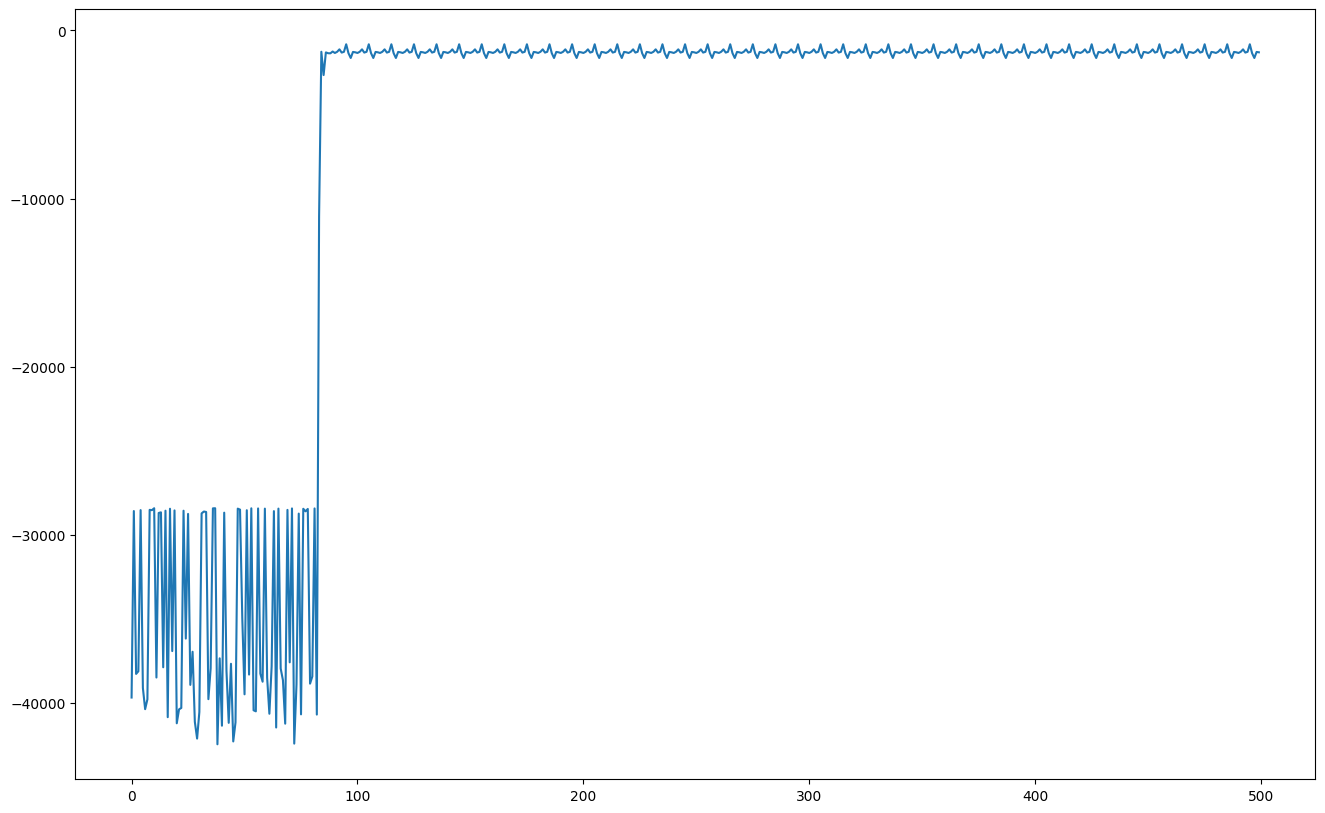

In [28]:
# from train import Trainer
from matplotlib import pyplot as plt
# import gym
from gym.envs.registration import register
gym.register(
    id='PointParticle-v0',
    entry_point=PointParticleEnv,   # or "__main__:PointParticleEnv"
    max_episode_steps=300    # ← choose a sensible episode length
)


env_name='PointParticle-v0'
trainer = Trainer(config_file=f'./configs/{env_name}.json',enable_logging=True)
episode_rewards, evaluations = trainer.train()

plt.figure(figsize=(16, 10))
plt.plot(episode_rewards)

#     ce0d0200dfea200450b86c341468e0ae12cf0570

In [30]:
trainer.evaluate()


/usr/local/lib/python3.11/dist-packages/gym/envs/registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes']
  logger.warn(


TypeError: PointParticleEnv.__init__() got an unexpected keyword argument 'render_mode'